# **EE6310 Image and Video Processing, Fall 2021**
---
> Homework 5

***In this assignment, implement a Convolutional Neural Network (CNN) in the feed forward mode. The CNN architecture must is as follows:***
* Conv layer with 4 kernels of size 3 × 3 and Rectified Linear Unit (ReLU) activation
* Max pooling layer of size 2 × 2 with a stride of 2 along each dimension
* Conv layer with 8 kernels of size 3 × 3 and Rectified Linear Unit (ReLU) activation
* Max pooling layer of size 2 × 2 with a stride of 2 along each dimension
* Flattening layer
* An MLP with one hidden layer that accepts as input the flattening layer output and maps it to 10 output nodes. Use ReLU activation for the MLP as well. 






In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import PIL
import cmath

**Dataset**

---



In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
dic = unpickle('/content/drive/MyDrive/Image and Video Processing/cifar-10-batches-py/test_batch')

In [ ]:
for key, value in dic.items():
  print(key, value,'\n')

b'batch_label' b'testing batch 1 of 1' 

b'labels' [3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 

In [ ]:
# Choosing 5 examples from each class and resizing each 1-D array back to 3x32x32
examples = []
for c in range(10):
  examples.append(np.array([dic[b'data'][i].reshape(3,32,32) for i in np.where(np.array(dic[b'labels']) == c)[0]])[:5])
print('Class 1 Shape',examples[1].shape)

Class 1 Shape (5, 3, 32, 32)


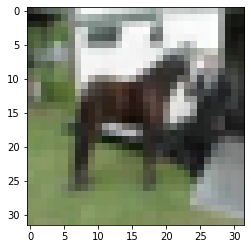

In [ ]:
# Changing index ordering for compatibility
plt.imshow(examples[7][2].transpose(1,2,0))
plt.show()

**Convolution Operation**

---



In [ ]:
def DFTMatrix(img):
  N = img.shape[0]
  W = np.ones_like(img, dtype = np.complex_)
  Wn = cmath.exp(-2j*(cmath.pi)/N)
  for p in range(1,N): 
    for q in range(p,N):
      W[p,q] = Wn**(p*q)
      W[q,p] = W[p,q]
  return W@img@W

In [ ]:
def iDFTMatrix(dft):
  N = dft.shape[0]
  W = np.ones_like(dft, dtype = np.complex_)
  Wn = cmath.exp(2j*(cmath.pi)/N)
  for p in range(1,N):
    for q in range(p,N):
      W[p,q] = Wn**(p*q)
      W[q,p] = W[p,q]
  return W@dft@W

In [ ]:
def DFTLinearConv(img, filter):
  '''Linear Convolution for 1 channel'''
  N, M = img.shape
  P, Q = filter.shape
  padded_img = np.pad(img, ((0,N),(0,M)),'constant')
  padded_filter = np.pad(filter,((0,N-P),(0,M-Q)),'constant')
  padded_filter = np.pad(padded_filter,((0,N),(0,M)),'constant')
  conv = iDFTMatrix(np.multiply(DFTMatrix(padded_img),DFTMatrix(padded_filter)))
  return conv[:N,:M].real

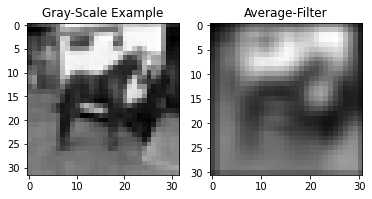

In [ ]:
average_filter = np.full((5,5), 1/25, dtype = float)

fig, ax = plt.subplots(1,2)
ax[0].imshow(examples[7][2,0],cmap='gray')
ax[0].set_title('Gray-Scale Example')
ax[1].imshow(DFTLinearConv(examples[7][2,0],average_filter),cmap='gray')
ax[1].set_title('Average-Filter')
plt.show()

**Convolutional Neural Network**

---



In [ ]:
def Conv(img, filters):
  ''' Add Linear Conv from all channels and normalize'''
  conv_tot = []
  for filter in filters:
    conv = DFTLinearConv(img[0],filter[0])
    for i in range(1,img.shape[0]):
      conv += DFTLinearConv(img[i],filter[i])
    conv = conv/(img.shape[0]*img.shape[1]*img.shape[2])
    conv_tot.append(conv)
  return np.asarray(conv_tot)

In [ ]:
def MaxPool(img):
  '''Implements 2x2 max pool operation with stride 2'''
  c = []
  for channel in img:
    new_ch = np.zeros((channel.shape[0]//2,channel.shape[1]//2))
    for i in range(0,channel.shape[0],2):
      for j in range(0, channel.shape[1],2):
        new_ch[i//2,j//2] = np.max(np.array([channel[i,j],channel[i+1,j],channel[i,j+1],channel[i+1,j+1]]))
    c.append(new_ch)
  return np.asarray(c)

In [ ]:
def ReLU(x):
  return np.maximum(np.zeros_like(x),x)

In [ ]:
def sigmoid(x):
  return np.exp(-np.logaddexp(0, -x))

In [ ]:
def softmax(z):
  '''Generate Labels for multi-class classfication (10 classes here)'''
  s = np.max(z, axis=1)
  s = s[:, np.newaxis] 
  e_x = np.exp(z - s)
  div = np.sum(e_x, axis=1)
  div = div[:, np.newaxis]
  return e_x / div

In [ ]:
def FCN(x_batch, alpha, beta):
  '''Fully connected network'''
  #Augment X matrix with 1s
  x_new = np.pad(x_batch,((1,0),(0,0)),constant_values = 1)

  #Compute hidden layer activations
  z = ReLU(alpha @ x_new)
  z_new = np.pad(z,((1,0),(0,0)),constant_values = 1)
  
  #Prediction from FP using given model parameters
  y_hat = softmax(beta @ z_new)
  return y_hat.T[0]

In [ ]:
def init_weights(init):
  '''Implements DoG and random initilization of kernel weights'''
  if init == 'bandpass':
    filt1 = []
    for s in np.arange(0.2,1.0,0.2):
      k = 1 #  generate a (2k+1)x(2k+1) gaussian
      probs = [np.exp(-z*z/(2*2.56*s*s))/np.sqrt(2*np.pi*2.56*s*s) - np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)] 
      gaussian_filter1 = np.outer(probs, probs)
      filt1.append([gaussian_filter1,gaussian_filter1,gaussian_filter1])
    filt1 = np.asarray(filt1)

    filt2 = []
    for s in np.arange(0.2,1.8,0.2):
      k = 1
      probs = [np.exp(-z*z/(2*2.56*s*s))/np.sqrt(2*np.pi*2.56*s*s) - np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)] 
      gaussian_filter2 = np.outer(probs, probs)
      filt2.append([gaussian_filter2,gaussian_filter2,gaussian_filter2,gaussian_filter2])
    filt2 = np.asarray(filt2)
  
  else:
    filt1 = np.random.randn(4,3,3,3)
    filt2 = np.random.randn(8,4,3,3)

  #Alpha Beta include biases
  alpha = np.random.randn(512,513)
  beta = np.random.randn(10,513)
  
  return filt1, filt2, alpha, beta

In [ ]:
def forward(img, init = 'bandpass'):
  '''conv->maxpool->conv->maxpool->FCN->softmax(Class probabilities)'''
  filt1, filt2, alpha, beta = init_weights(init)
  # print(filt1.shape)
  # print(filt2.shape)

  conv1 = ReLU(Conv(img, filt1))
  # print('c1',conv1.shape)
  max1 = MaxPool(conv1)
  # print('m1',max1.shape)
  conv2 = ReLU(Conv(max1, filt2))
  # print('c2',conv2.shape)
  max2 = MaxPool(conv2)
  # print('m2',max2.shape)

  pred = FCN(max2.reshape(-1,1), alpha, beta)
  return pred, conv1, max1, conv2, max2

In [ ]:
# Random Weight Init. Predictions and activations
pred_R, conv1_R, max1_R, conv2_R, max2_R = forward(examples[7][2], init = 'random')

In [ ]:
# DoG Weight Init. Predictions and activations
pred, conv1, max1, conv2, max2 = forward(examples[7][2], init = 'bandpass')

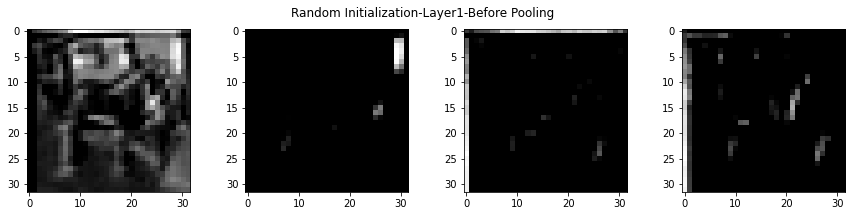

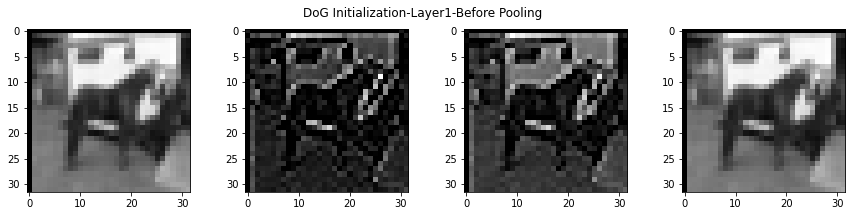

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(15,3))

for i in range(conv1.shape[0]):
  ax[i].imshow(conv1_R[i],cmap='gray')
fig.suptitle('Random Initialization - Layer1 - Before Pooling')
plt.show()

fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(conv1.shape[0]):
  ax[i].imshow(conv1[i],cmap='gray')
fig.suptitle('DoG Initialization - Layer1 - Before Pooling')
plt.show()

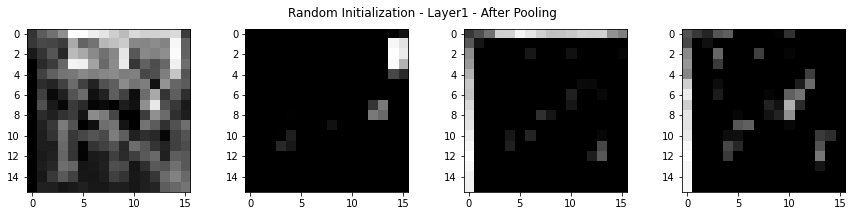

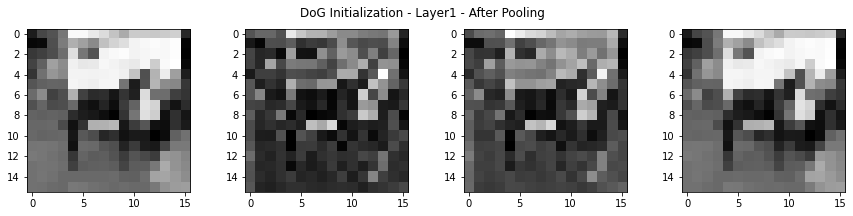

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(15,3))

for i in range(max1.shape[0]):
  ax[i].imshow(max1_R[i],cmap='gray')
fig.suptitle('Random Initialization - Layer1 - After Pooling')
plt.show()

fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(max1.shape[0]):
  ax[i].imshow(max1[i],cmap='gray')
fig.suptitle('DoG Initialization - Layer1 - After Pooling')
plt.show()

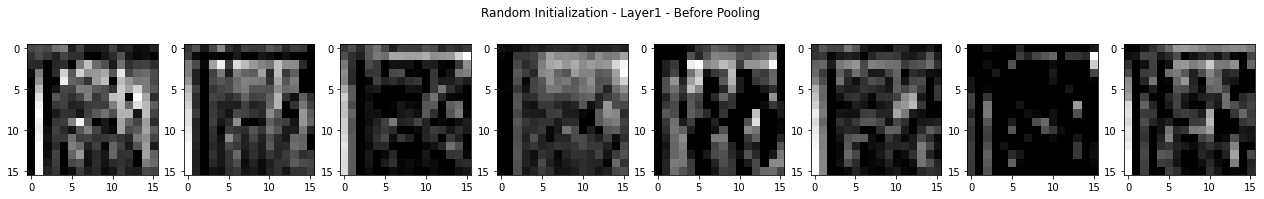

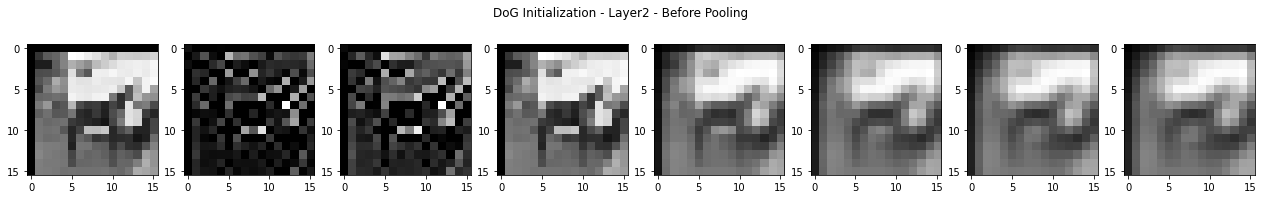

In [ ]:
fig, ax = plt.subplots(1,8, figsize=(22,3))

for i in range(conv2.shape[0]):
  ax[i].imshow(conv2_R[i],cmap='gray')
fig.suptitle('Random Initialization - Layer1 - Before Pooling')
plt.show()

fig, ax = plt.subplots(1,8, figsize=(22,3))
for i in range(conv2.shape[0]):
  ax[i].imshow(conv2[i],cmap='gray')
fig.suptitle('DoG Initialization - Layer2 - Before Pooling')
plt.show()

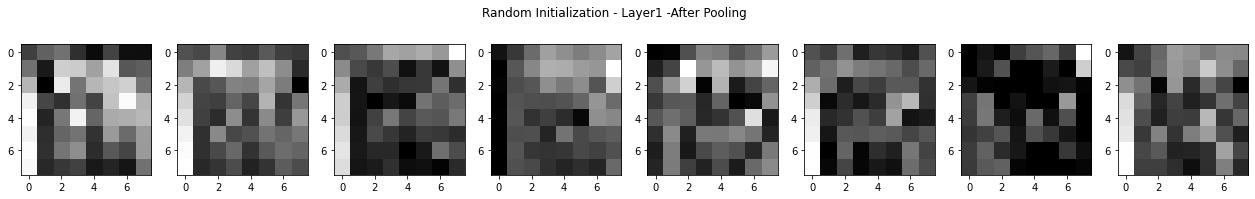

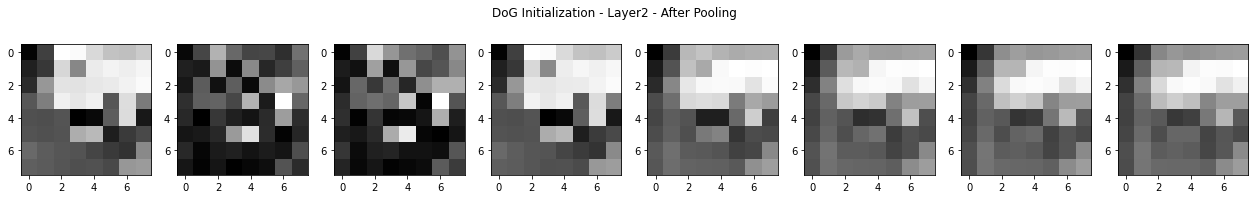

In [ ]:
fig, ax = plt.subplots(1,8, figsize=(22,3))

for i in range(max2.shape[0]):
  ax[i].imshow(max2_R[i],cmap='gray')
fig.suptitle('Random Initialization - Layer1 -After Pooling')
plt.show()

fig, ax = plt.subplots(1,8, figsize=(22,3))
for i in range(max2.shape[0]):
  ax[i].imshow(max2[i],cmap='gray')
fig.suptitle('DoG Initialization - Layer2 - After Pooling')
plt.show()

Here, smoothing an image using a Gaussian kernel suppresses only high-frequency spatial information. Subtracting one image from the other preserves spatial information that lies between the range of frequencies that are preserved in the two smoothed images. Thus, the difference-of-Gaussians is a band-pass filter. The difference-of-Gaussians filter can be used to emphasize edges present in an image. The difference-of-Gaussians filter can remove high-frequency noise while emphasizing edges.

For us, clearly these kernel outputs are the edge enhances features. This makes out DoG intitilization better than random as the kernels output meaningful representations of the original image.

More th variance, the effect of subtraction reduces as the kernel size in only 3x3. So, in a certain small value range of variances, we observe edges being enhanced.

**t-SNE Plots of different representations of data**

---



In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Concatenating all class images into a vector
data = np.asarray(examples).reshape(-1,3,32,32)

In [ ]:
# Making sure that all the examples are in order of the classes to which they belong
for i in range(0,46,5):
  assert np.allclose(data[i:i+5], examples[i//5])

In [ ]:
print(data.shape)

(50, 3, 32, 32)


In [ ]:
# Representations of flattened outputs at bottleneck layer
repr = []
for img in data:
  repr.append(forward(img, init='bandpass')[4].reshape(-1,1))

repr1 = []
for img in data:
  repr1.append(forward(img, init='random')[4].reshape(-1,1))

In [ ]:
repr = np.asarray(repr,dtype='float')
repr1 = np.asarray(repr1,dtype='float')

In [ ]:
repr = repr.reshape(50,-1)
repr1 = repr1.reshape(50,-1)
print('Representation Shape',repr.shape)

Representation Shape (50, 512)


In [ ]:
# t-SNE to reduce dimensionality to plot and observe correlation within class and between-class seperation.
X_embedded = TSNE(n_components=2, init='pca').fit_transform(repr)
X_embedded1 = TSNE(n_components=2, init='pca').fit_transform(repr1)

In [ ]:
print('Embedding Shape',X_embedded.shape)

Embedding Shape (50, 2)


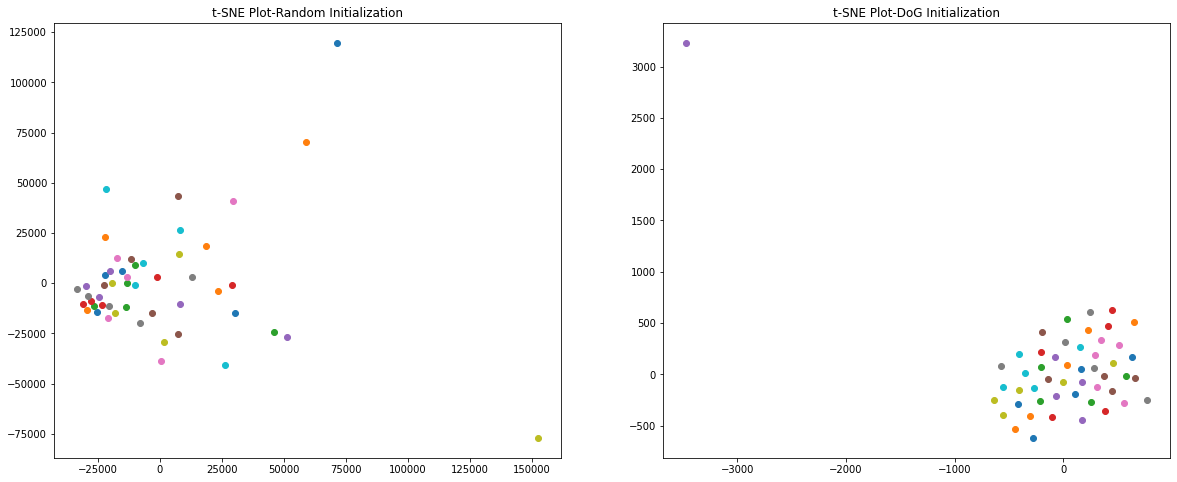

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
for i in range(0,46,5):
  ax[0].scatter(X_embedded1[i:i+5,0],X_embedded1[i:i+5,1])
ax[0].set_title('t-SNE Plot-Random Initialization')

for i in range(0,46,5):
  ax[1].scatter(X_embedded[i:i+5,0],X_embedded[i:i+5,1])
ax[1].set_title('t-SNE Plot-DoG Initialization')
plt.show()

Clearly, the scale in random initilization is way larger than DoG t-SNE plots. Also, the classes have no seperation whatsoever in random initialization as the representations are not meaniningful. The representaino odtained with DoG initialization is more meaninigful as they capture edge information. Thus, we see some degree of seperability in the latter plot.

In [ ]:
# Representation after flattening output from first maxpool layer.
repr2 = []
for img in data:
  repr2.append(forward(img, init='bandpass')[2].reshape(-1,1))

repr3 = []
for img in data:
  repr3.append(forward(img, init='random')[2].reshape(-1,1))

In [ ]:
repr2 = np.asarray(repr2,dtype='float')
repr3 = np.asarray(repr3,dtype='float')

In [ ]:
repr2 = repr2.reshape(50,-1)
repr3 = repr3.reshape(50,-1)
print('Representation Shape',repr2.shape)

Representation Shape (50, 1024)


In [ ]:
X_embedded2 = TSNE(n_components=2, init='pca').fit_transform(repr2)
X_embedded3 = TSNE(n_components=2, init='pca').fit_transform(repr3)

In [ ]:
print('Embedding Shape',X_embedded2.shape)

Embedding Shape (50, 2)


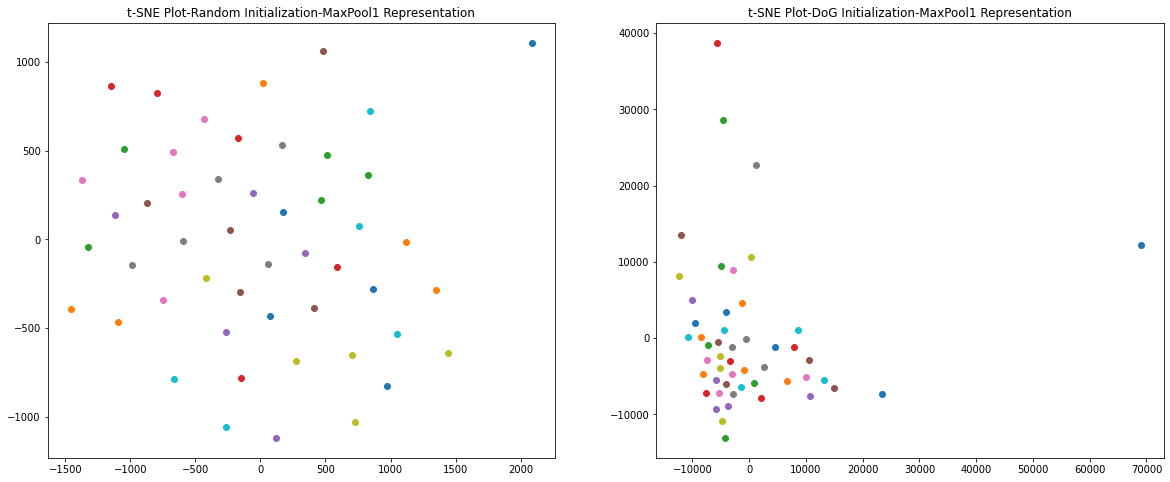

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
for i in range(0,46,5):
  ax[0].scatter(X_embedded2[i:i+5,0],X_embedded2[i:i+5,1])
ax[0].set_title('t-SNE Plot-Random Initialization-MaxPool1 Representation')

for i in range(0,46,5):
  ax[1].scatter(X_embedded3[i:i+5,0],X_embedded3[i:i+5,1])
ax[1].set_title('t-SNE Plot-DoG Initialization-MaxPool1 Representation')
plt.show()

In cases where variance of DoG kernels are really high, the filter does nothing and hence the representations might not be as good as the other DoG kernels.

Clearly, even here we can tell that DoG initialization gives a more meaningful representation, due to which the classes are somewhat seperable after t-SNE dimensionality reduction due to the reasons give for above plots.
